# Model samples

In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tdt17_project.model import get_unet_model, load_state_dict
from tdt17_project.data import get_dataset, get_val_test_transform
from tdt17_project.utils import CityscapesContants, decode_segmap, encode_segmap
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import MulticlassJaccardIndex
import torchvision.transforms as transforms
from PIL import Image
from typing import cast
import torch.nn as nn
from typing import NamedTuple, TypedDict, Protocol, Any, Callable
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
val_transforms = get_val_test_transform()
val_data = get_dataset("../../datasets/Cityscapes/", "val", val_transforms)
model = get_unet_model(in_channels=3, out_channels=len(CityscapesContants.VALID_CLASSES))
model, *_ = load_state_dict(model, None, "./weights/242323_model.pt")
loss_criterion = DiceLoss(mode="multiclass")
metric = MulticlassJaccardIndex(num_classes=len(CityscapesContants.VALID_CLASSES), average="macro")
model.to("cuda")
loss_criterion.to("cuda")
metric.to("cuda")



MulticlassJaccardIndex()

In [41]:




def show_samples(
    model: nn.Module,
    examples: list[tuple[torch.Tensor, torch.Tensor]],
    device: str = "cuda",
):
    print("\n*** Model examples ***")
    model.eval()
    with torch.no_grad():
        for i, (image, target) in enumerate(examples):
            image_prep = image.to(device).float().unsqueeze(0)
            target_prep = encode_segmap(target.to(device).long()).unsqueeze(0)  # to remove unwanted classes
            pred = model(image_prep)
            loss = loss_criterion(pred, target_prep)
            metric_score = metric(pred, target_prep)
            decoded_pred = decode_segmap(
                torch.argmax(pred.squeeze(0).detach().cpu(), dim=0)
            )
            decoded_target = decode_segmap(target_prep.squeeze(0).detach().cpu())
            score_str = f"[loss: {loss:.3f}, mIoU: {metric_score:.3f}]",
            _, ax = plt.subplots(ncols=3, figsize=(12, 30), facecolor="white")
            ax[0].imshow(np.moveaxis(image.numpy(), 0, 2))
            ax[1].imshow(decoded_target)
            ax[2].imshow(decoded_pred)
            ax[0].axis("off")
            ax[1].axis("off")
            ax[2].axis("off")
            ax[0].set_title("Input Image")
            ax[1].set_title("Ground mask")
            ax[2].set_title(f"Predicted mask, {score_str}")
                

        

## Samples from dataset


*** Model examples ***


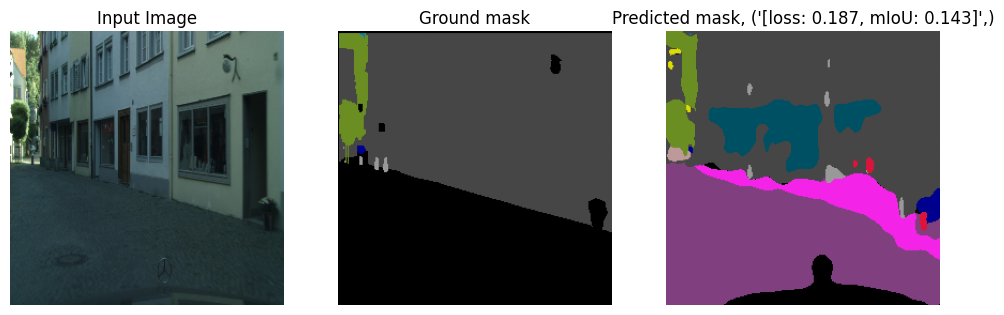

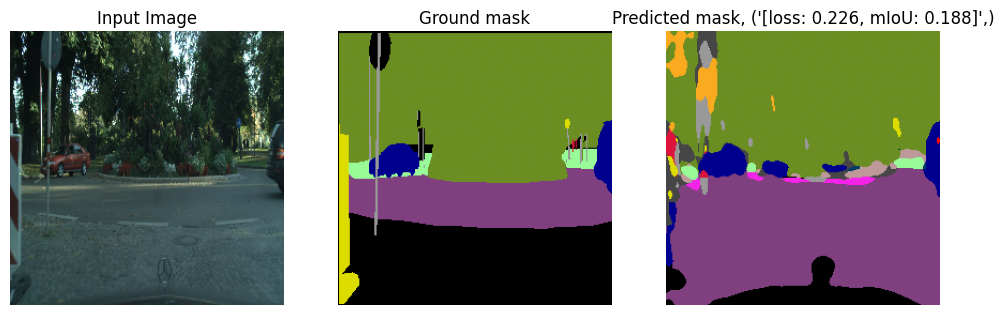

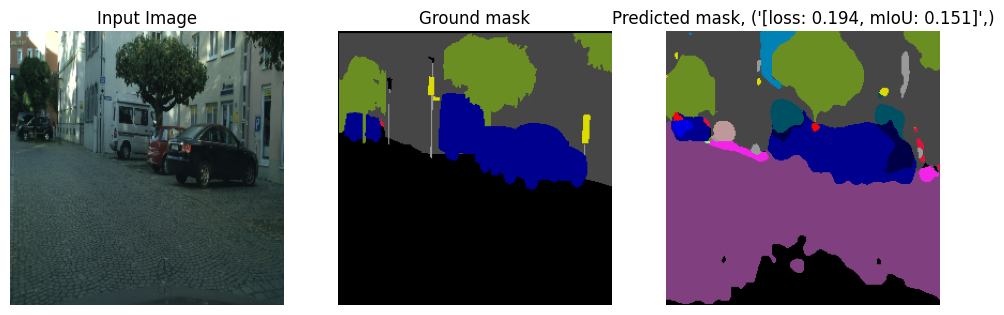

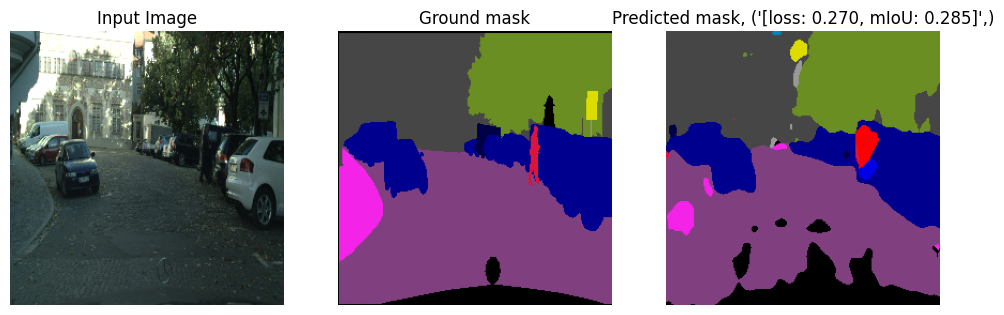

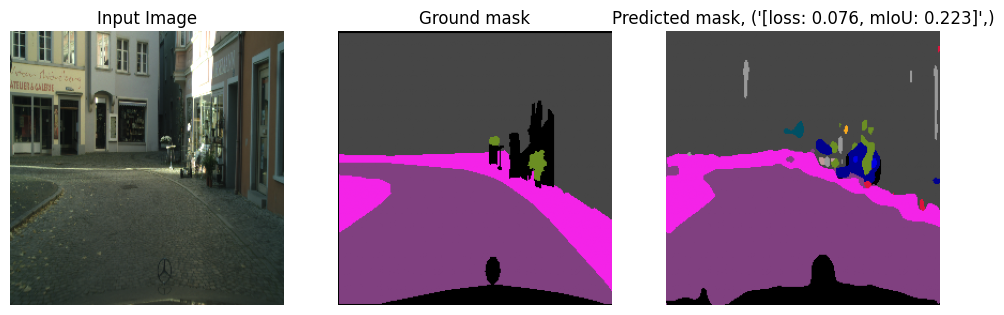

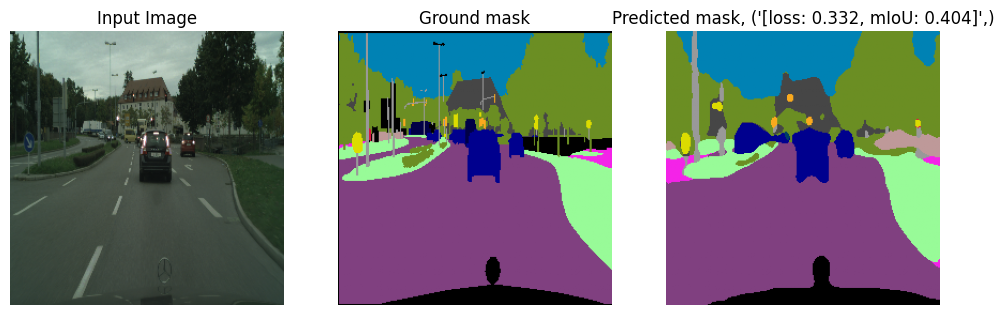

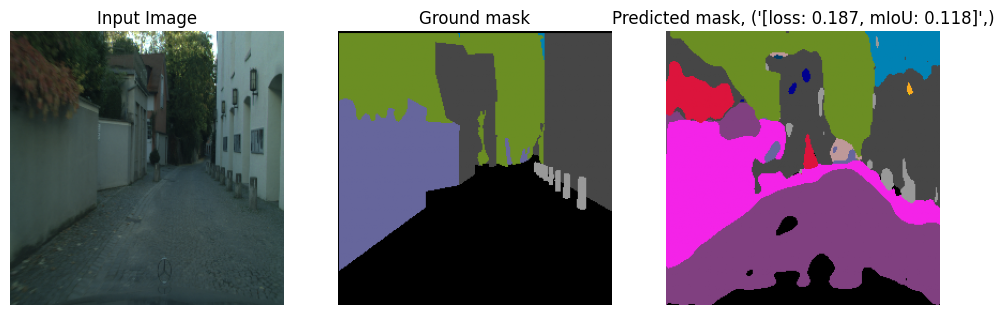

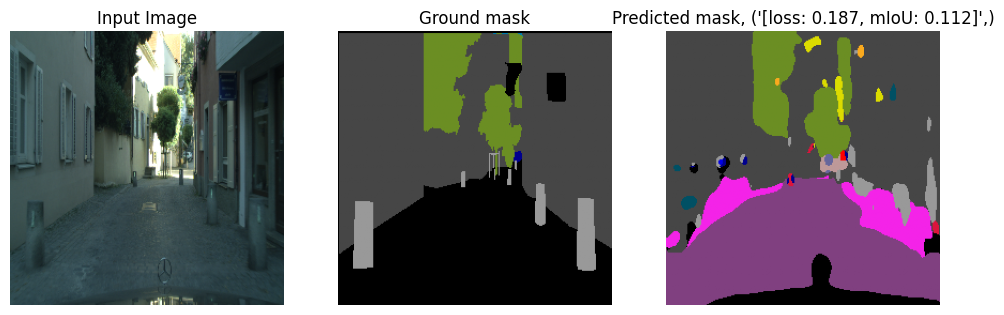

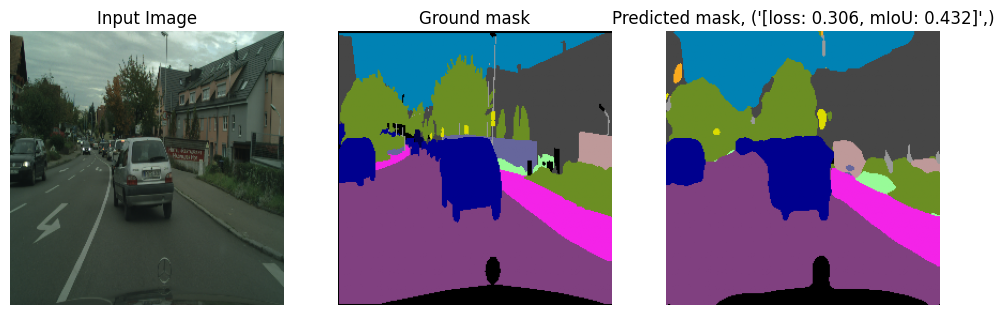

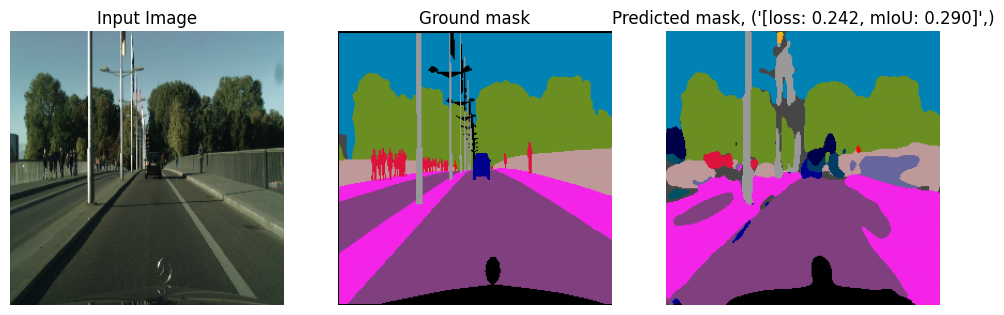

In [42]:
val_samples = [val_data[i] for i in range(10)]
show_samples(model, val_samples)

## Trondheim samples

In [43]:

def show_samples_from_image(model: torch.nn.Module, samples_paths: list[str], device="cuda"):
    images = [Image.open(image_path).convert("RGB") for image_path in samples_paths]
    examples = cast(list[torch.Tensor], [val_transforms(image, image)[0] for image in images])
    model.eval()
    with torch.no_grad():
        for image in examples:
            image_prep = image.to(device).float().unsqueeze(0)
            pred = model(image_prep)
            decoded_pred = decode_segmap(
                torch.argmax(pred.squeeze(0).detach().cpu(), dim=0)
            )
            _, ax = plt.subplots(ncols=2, figsize=(10, 20), facecolor="white")
            ax[0].imshow(np.moveaxis(image.numpy(), 0, 2))
            ax[1].imshow(decoded_pred)
            ax[0].axis("off")
            ax[1].axis("off")
            ax[0].set_title("Input Image")
            ax[1].set_title(f"Predicted mask")
    

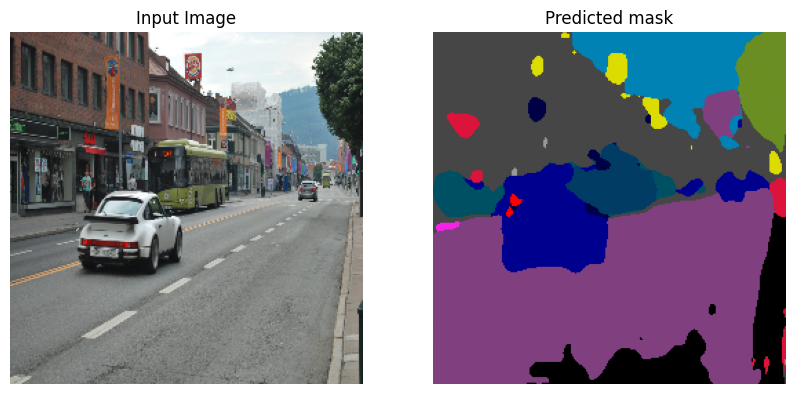

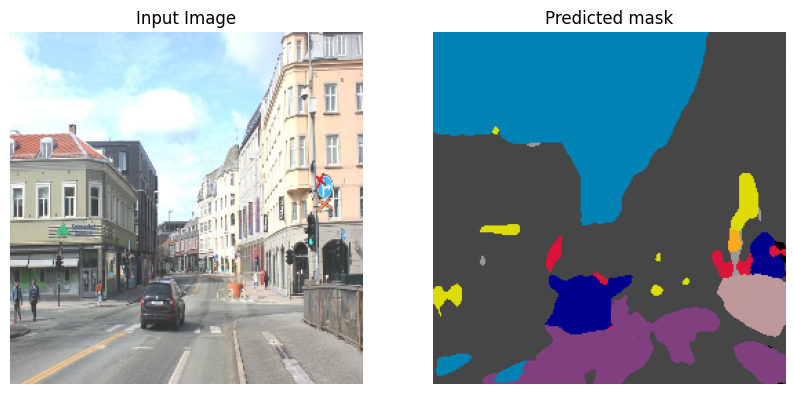

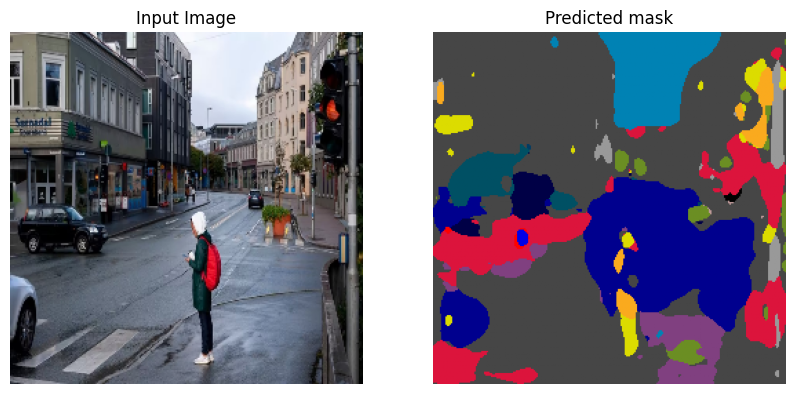

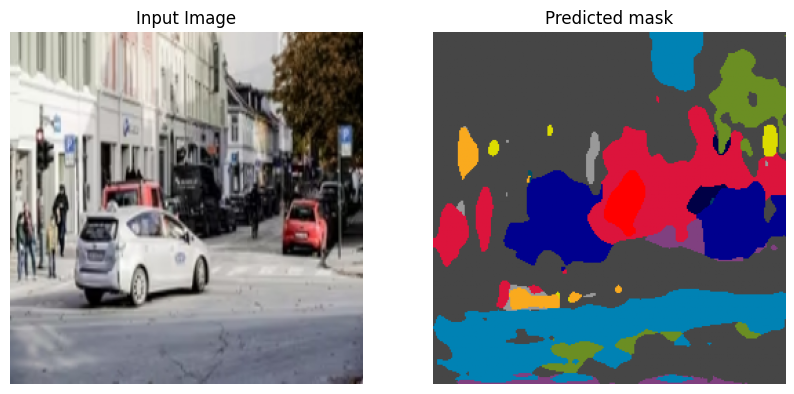

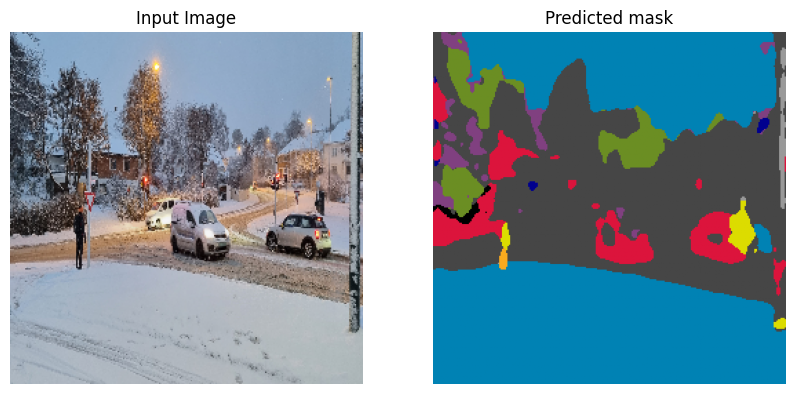

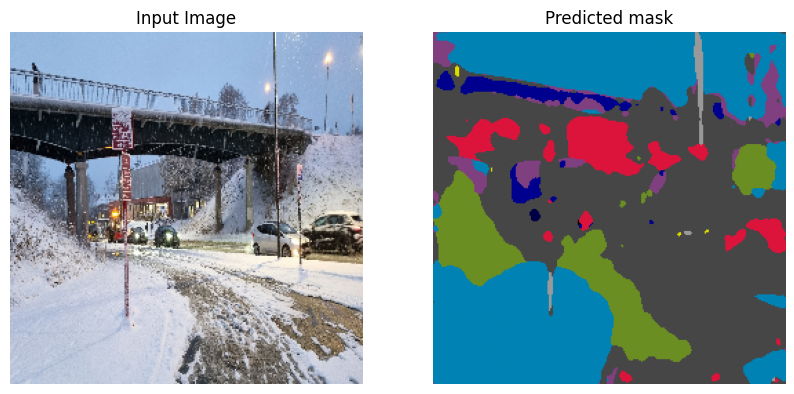

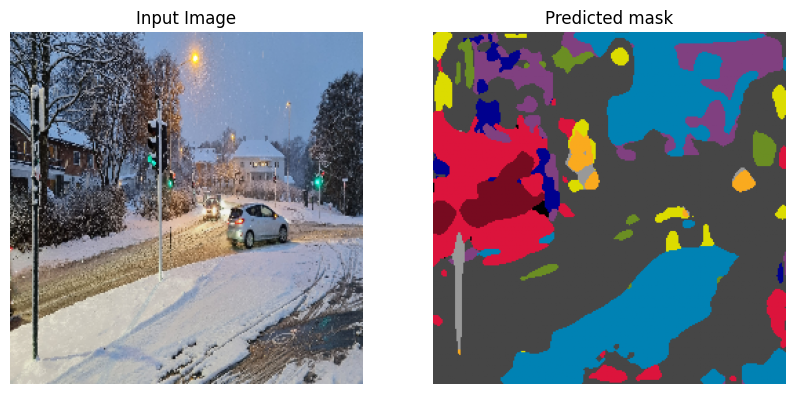

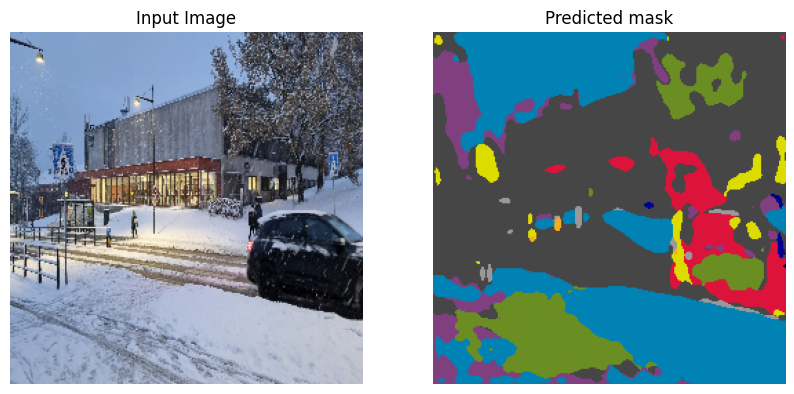

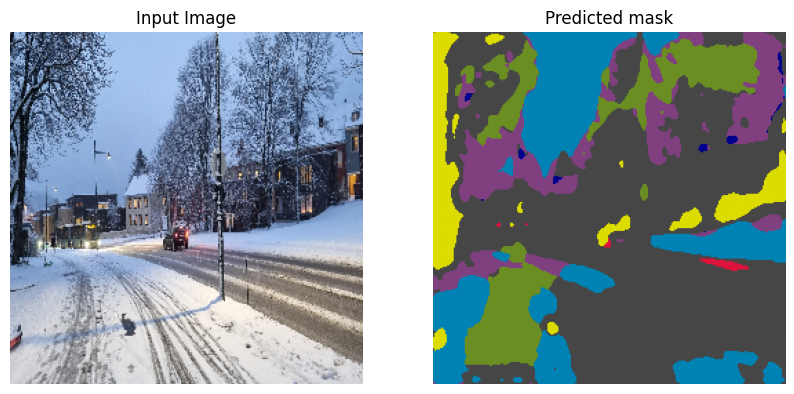

In [44]:
trondheim_samples = [
    "./trondheim_images/trondheim1.jpg",
    "./trondheim_images/trondheim2.jpg",
    "./trondheim_images/trondheim3.jpg",
    "./trondheim_images/trondheim4.jpg",
    "./trondheim_images/2023-11-24 15.30.40.jpg",
    "./trondheim_images/2023-11-24 15.30.54.jpg",
    "./trondheim_images/2023-11-24 15.31.07.jpg",
    "./trondheim_images/2023-11-24 15.31.32.jpg",
    "./trondheim_images/2023-11-24 15.32.24.jpg",
]
# trondheim_samples = [
#     "../../datasets/Cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png",
# ]
show_samples_from_image(model, trondheim_samples)